In [3]:
import tensorflow as tf
import matplotlib.pyplot as plt
import qriemannopt as qro

C:\Users\HYPERPC\Anaconda3\lib\site-packages\numpy\core\numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


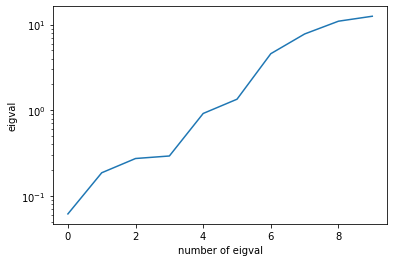

In [55]:
ham_dim = 10 # dimension of hamiltonian

# hamiltonian
Q = qro.manifold.real_to_complex(tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64))
Q, _ = tf.linalg.qr(Q)
S = tf.random.uniform((ham_dim,), -3, 3)
S = tf.exp(S)
S = tf.cast(S, dtype=tf.complex128)
H = tf.einsum('ik,k,jk->ij', Q, S, tf.math.conj(Q))

plt.plot(tf.linalg.eigvalsh(H))
plt.yscale('log')
plt.xlabel('number of eigval')
plt.ylabel('eigval')

# min of loss function
min_value = tf.cast(tf.linalg.eigvalsh(H)[0],
                   dtype=tf.float64)

'''# in dens matrix
rho = tf.eye(ham_dim, dtype=tf.complex128)
rho = rho / tf.linalg.trace(rho)
rho = qro.manifold.complex_to_real(rho)'''
rho = tf.random.normal((ham_dim, ham_dim, 2), dtype=tf.float64)
rho = qro.manifold.real_to_complex(rho)
rho = tf.linalg.adjoint(rho) @ rho
rho = rho / tf.linalg.trace(rho)
rho = qro.manifold.complex_to_real(rho)

# manifold of dens matrices
m = qro.manifold.densmv2.DensM()

# optimizers
opts = {
        'GD':qro.optimizers.RSGD(m, 0.001),
        'GD_momentum':qro.optimizers.RSGD(m, 0.001, 0.9),
        'Adam':qro.optimizers.RAdam(m, 0.001),
        'Adam_with_ams':qro.optimizers.RAdam(m, 0.001, ams=True)
       }

In [56]:
list_of_losses = {}
#list_of_lambdas = {}
# loop over optimizers
for key, opt in opts.items():
    # training loop
    losses = []
    #lambdas = []
    rho_var = tf.Variable(rho)
    for _ in range(1000):
        with tf.GradientTape() as tape:
            loss = tf.linalg.trace(qro.manifold.real_to_complex(rho_var) @ H)
            loss = tf.cast(loss, tf.float64)
            losses.append(loss - min_value)
            #lambdas.append(tf.reduce_min(tf.cast(tf.linalg.eigvalsh(qro.manifold.real_to_complex(rho_var)), dtype=tf.float64)))
        grad = tape.gradient(loss, rho_var)
        opt.apply_gradients(zip([grad], [rho_var]))
    list_of_losses[key] = losses
    #list_of_lambdas[key] = lambdas

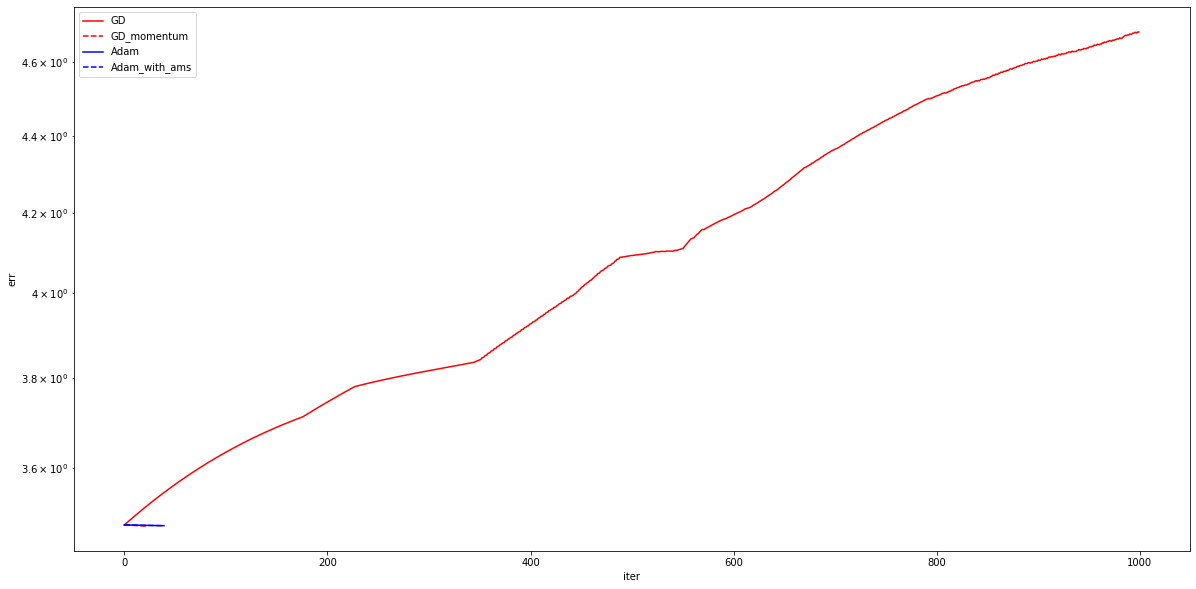

In [57]:
# learning curves
colors = ['r', 'r--', 'b', 'b--', 'k', 'k--', 'g', 'g--', 'r:', 'r-.', 'b:', 'b-.', 'k:', 'k-.', 'g:', 'g-.', 'purple']
plt.figure(figsize=(20, 10))
for i, key in enumerate(opts.keys()):
    plt.plot(list_of_losses[key], colors[i])
plt.legend(opts.keys())
plt.yscale('log')
plt.xlabel('iter')
plt.ylabel('err')
plt.savefig('Riemann_opt_first_test.pdf')

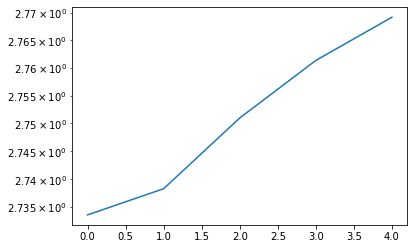

In [54]:
plt.plot(losses)
plt.yscale('log')

In [48]:
losses

[<tf.Tensor: shape=(), dtype=float64, numpy=-2.862280318547085>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.8593383277060407>,
 <tf.Tensor: shape=(), dtype=float64, numpy=-2.8621760522345747>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <t

In [ ]:
L @ qro.manifold.densm.adj(L)

In [28]:
m = qro.manifold.densmv2.DensM()
'''rho = qro.manifold.real_to_complex(tf.random.normal((10, 10, 2), dtype=tf.float64))
rho = qro.manifold.densm.adj(rho) @ rho
rho = rho / tf.linalg.trace(rho)'''
rho = tf.eye(10, dtype=tf.complex128) / 10
E = tf.random.normal((10, 10, 2), dtype=tf.float64)
E = qro.manifold.real_to_complex(E)
E = E + qro.manifold.densm.adj(E)
E = E - tf.linalg.trace(E)[tf.newaxis, tf.newaxis] * tf.eye(10, dtype=tf.complex128) / 10
R = m.egrad_to_rgrad(rho, E)
m.retraction(rho, R)

<tf.Tensor: shape=(10, 10), dtype=complex128, numpy=
array([[nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj, nan+nanj,
        nan+nanj, nan+nanj, nan+nanj, nan+nanj],
       [nan

In [8]:
l = tf.linalg.eigvalsh(rho)
qro.manifold.densmv2.f_matrix(l)

<tf.Tensor: shape=(10, 10), dtype=complex128, numpy=
array([[0.00032966+0.j, 0.00092348+0.j, 0.00463473+0.j, 0.00586512+0.j,
        0.01246173+0.j, 0.01687382+0.j, 0.02202102+0.j, 0.02679771+0.j,
        0.03248875+0.j, 0.04150649+0.j],
       [0.00092348+0.j, 0.00198988+0.j, 0.0075809 +0.j, 0.00932543+0.j,
        0.01837412+0.j, 0.0242697 +0.j, 0.03105734+0.j, 0.0372945 +0.j,
        0.04466733+0.j, 0.05625218+0.j],
       [0.00463473+0.j, 0.0075809 +0.j, 0.01915788+0.j, 0.0223743 +0.j,
        0.03802578+0.j, 0.04770716+0.j, 0.05856546+0.j, 0.06834935+0.j,
        0.0797355 +0.j, 0.09733099+0.j],
       [0.00586512+0.j, 0.00932543+0.j, 0.0223743 +0.j, 0.02593202+0.j,
        0.04306139+0.j, 0.05356299+0.j, 0.06528794+0.j, 0.07581667+0.j,
        0.08803624+0.j, 0.10686459+0.j],
       [0.01246173+0.j, 0.01837412+0.j, 0.03802578+0.j, 0.04306139+0.j,
        0.06645441+0.j, 0.08036272+0.j, 0.09564825+0.j, 0.10921099+0.j,
        0.12480132+0.j, 0.14857711+0.j],
       [0.01687382+0.j

In [ ]:
plt.imshow(tf.math.abs(m.egrad_to_rgrad(rho, E)))

In [20]:
rhoc = qro.manifold.real_to_complex(rho)

In [ ]:
tf.exp(lmbd)

In [ ]:
m = qro.manifold.DensM()
rho = qro.manifold.real_to_complex(tf.random.normal((10, 10, 2), dtype=tf.float64))
grad = qro.manifold.real_to_complex(tf.random.normal((10, 10, 2), dtype=tf.float64))
rho = qro.manifold.densm.adj(rho) @ rho
m.egrad_to_rgrad(rho, grad)

In [24]:
rho

<tf.Tensor: shape=(10, 10), dtype=complex128, numpy=
array([[0.1+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0.1+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0.1+0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0.1+0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.1+0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.1+0.j, 0. +0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0.1+0.j,
        0. +0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0.1+0.j, 0. +0.j, 0. +0.j],
       [0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j, 0. +0.j,
        0. +0.j, 0.1